# KMERAI DEMO: jobs Classification with fastText

The goal of this notebook is to predict, base on the job description, the category class of the giben job.

This quick tutorial introduces the task of text classification using the [fastText](https://fasttext.cc/) library and tries to show what the full pipeline looks like from the beginning (obtaining the dataset and preparing the train/valid split) to the end (predicting labels for unseen input data).

source: https://www.kaggle.com/datasets/PromptCloudHQ/us-jobs-on-monstercom/metadata?resource=download

## The US jobs on Monster.com dataset

We'll use a dataset of more than 4.7 million job listings on [Monster.com](https://www.monster.com/) and we will transform it in fastText format -- basically a text file where each line contains one text document that is to be classified. Note that the lines start with `__label__` tags which denote the "ground truth" label for that particular text document.


`__label__<X> __label__<Y> ... <Text>`


For example:

`__label__management an Aegion company, is looking for a Video Data Quality...`

--------------------------

In the next few cells we'll download the dataset and take a closer look at what the data looks like (using the [`head`](https://linux.101hacks.com/unix/head/) command) and some further statistics about the dataset (using the [`wc`](https://www.tecmint.com/wc-command-examples/) -- command).

In [7]:
import pandas as pd
import pandas as pd
import numpy as np
import re
from tqdm import tqdm
 
import nltk
en_stop = set(nltk.corpus.stopwords.words('english'))
 
from gensim.models.fasttext import FastText
 
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import seaborn as sns
import matplotlib.pyplot as plt
 
# Lemmatization
from nltk.stem import WordNetLemmatizer
stemmer = WordNetLemmatizer()

In [8]:
# Text cleaning function for gensim fastText word embeddings in python
def process_text(document):
    # Remove extra white space from text
    document = re.sub(r'\s+', ' ', document, flags=re.I)

    # Remove all the special characters from text
    document = re.sub(r'\W', ' ', str(document))

    # Remove all single characters from text
    document = re.sub(r'\s+[a-zA-Z]\s+', ' ', document)

    # Converting to Lowercase
    document = document.lower()

    # Word tokenization       
    tokens = document.split()
    # Lemmatization using NLTK
    lemma_txt = [stemmer.lemmatize(word) for word in tokens]
    # Remove stop words
    lemma_no_stop_txt = [word for word in lemma_txt if word not in en_stop]
    # Drop words 
    tokens = [word for word in tokens if len(word) > 3]

    clean_txt = ' '.join(lemma_no_stop_txt)

    return clean_txt

In [ ]:
df = pd.read_csv("job_dataset.csv",sep=";")

In [38]:
df.shape

(6673, 5)

In [39]:
df.head()

,Unnamed: 0,job_description,job_title,sector,category
0,0,TeamSoft is seeing an IT Support Specialist to...,IT Support Technician Job in Madison,IT/Software Development,it
1,5,Job Description Job #: 720298Apex Systems has...,Construction PM - Charlottesville Job in Charl...,Experienced (Non-Manager),experienced
2,8,"Part-Time, 4:30 pm - 9:30 pm, Mon - Fri Brookd...",Housekeeper Job in Austin,Customer Support/Client Care,customer support
3,10,Aflac Insurance Sales Agent While a career in ...,Aflac Insurance Sales Agent Job in Berryville,Customer Support/Client Care,customer support
4,11,Enjoy making a great first impression? Our Sal...,Sales Associate Job in Columbus,Customer Support/Client Care,customer support


<AxesSubplot:ylabel='category'>

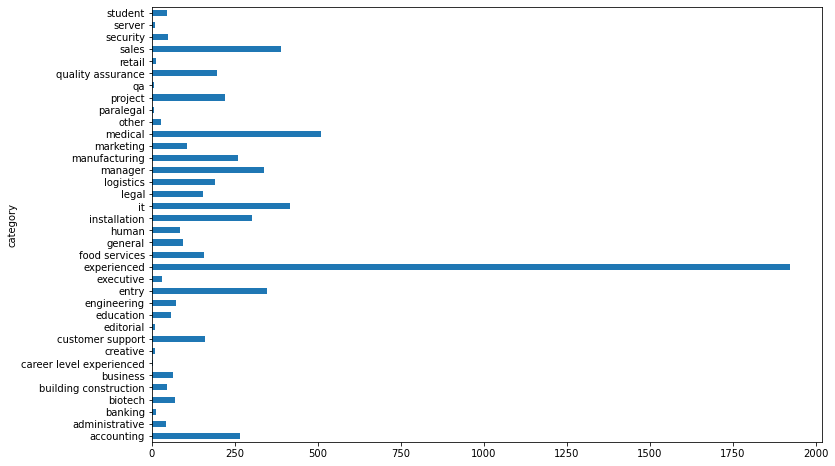

In [45]:
df.groupby('category')['job_description'].count().plot(kind='barh', figsize=(12,8))

In [11]:
description_corpus = list(df['job_description'])

In [15]:
clean_corpus = [process_text(sentence) for sentence in tqdm(description_corpus) if sentence.strip() !='']
 
word_tokenizer = nltk.WordPunctTokenizer()
word_tokens = [word_tokenizer.tokenize(sent) for sent in tqdm(clean_corpus)]



  0%|          | 0/6673 [01:16<?, ?it/s]


  0%|          | 1/6673 [00:01<2:35:58,  1.40s/it]

  1%|          | 77/6673 [00:01<01:33, 70.82it/s] 

  2%|▏         | 163/6673 [00:01<00:40, 162.69it/s]

  4%|▎         | 246/6673 [00:01<00:24, 257.82it/s]

  5%|▍         | 318/6673 [00:01<00:18, 335.26it/s]

  6%|▌         | 389/6673 [00:01<00:15, 395.52it/s]

  7%|▋         | 466/6673 [00:02<00:13, 474.52it/s]

  8%|▊         | 537/6673 [00:02<00:11, 529.12it/s]

  9%|▉         | 622/6673 [00:02<00:09, 608.80it/s]

 11%|█         | 705/6673 [00:02<00:08, 663.76it/s]

 12%|█▏        | 784/6673 [00:02<00:08, 696.84it/s]

 13%|█▎        | 862/6673 [00:02<00:08, 691.67it/s]

 14%|█▍        | 963/6673 [00:02<00:07, 777.39it/s]

 16%|█▌        | 1046/6673 [00:02<00:07, 738.10it/s]

 17%|█▋        | 1144/6673 [00:02<00:06, 803.62it/s]

 18%|█▊        | 1230/6673 [00:02<00:06, 816.21it/s]

 20%|█▉        | 1321/6673 [00:03<00:06, 840.86it/s]

 21%|██        | 1416/6673 [00:03<00:06, 871.31it/s]

In [47]:
len(clean_corpus)

6673

In [48]:
len(word_tokens)

6673

In [18]:
#word_tokens[:2]

## Train fastText word embeddings python

In [20]:
# Defining values for parameters
embedding_size = 300
window_size = 5
min_word = 5
down_sampling = 1e-2
 
%time
fast_Text_model = FastText(word_tokens,
                      size=embedding_size,
                      window=window_size,
                      min_count=min_word,
                      sample=down_sampling,
                      workers = 4,
                      sg=1,
                      iter=100)

CPU times: user 1 µs, sys: 1 µs, total: 2 µs
Wall time: 5.48 µs


In [21]:
from gensim.models import Word2Vec
# Save fastText gensim model
fast_Text_model.save("ft_model")

## Load saved gensim fastText model

In [22]:
fast_Text_model = Word2Vec.load("ft_model")

In [420]:
# Check word embedding for a perticular word
fast_Text_model.wv['php'].shape

(300,)

In [421]:
fast_Text_model.wv['php']

array([ 0.47154996, -0.5385316 , -1.0702249 ,  0.14381443, -0.34787083,
       -0.34851724, -0.18766901, -0.15059078,  0.21502893,  0.29635158,
        0.8088966 ,  0.52767944,  0.7984106 ,  0.43403485,  0.00164876,
       -0.08142822,  0.03877968,  0.26093104, -0.15712214, -0.84261924,
       -0.33610156, -0.04219335, -0.23778145, -0.15342338, -0.4106818 ,
        0.32586935, -0.30387643, -0.34317118,  0.2649446 ,  0.10058807,
       -0.44145474,  0.20605502,  0.38810897,  0.26630577, -0.40555635,
       -0.18730812, -0.01404773,  0.0427447 , -0.04268811, -0.24148352,
        0.25408086, -0.03693491,  0.09477597, -0.57325226, -0.20779167,
        0.05051378, -0.07622297,  0.1374497 ,  0.4433795 , -0.03826925,
        0.5798488 , -0.19464663, -0.2349924 ,  0.14943936, -0.37479857,
       -0.16971357, -0.5521328 ,  0.6641065 ,  0.13679343,  0.00681442,
        0.0271311 ,  0.18397732,  0.34501746, -0.75881207,  0.20457499,
       -0.0622588 ,  0.46520686, -0.806003  , -0.10781436,  0.05

In [31]:
# Check top 10 similar word for a given word by gensim fastText
fast_Text_model.wv.most_similar('php', topn=10)

[('java', 0.4728028178215027),
 ('mysql', 0.46914106607437134),
 ('python', 0.45565277338027954),
 ('javascript', 0.4515426754951477),
 ('jquery', 0.4338839650154114),
 ('node', 0.4337623119354248),
 ('ember', 0.4315042197704315),
 ('ajax', 0.4300656318664551),
 ('angularjs', 0.42451247572898865),
 ('xhtml', 0.40943750739097595)]

In [35]:
# Check top 10 similarity score between two word
fast_Text_model.wv.similarity('php', 'html')

0.3233458

In [33]:
# Most opposite to a word
fast_Text_model.wv.most_similar(negative=["php"], topn=10)

[('circle', 0.09757086634635925),
 ('monitor', 0.09508572518825531),
 ('nevada', 0.0808035358786583),
 ('abnormal', 0.07999687641859055),
 ('analyzes', 0.07786853611469269),
 ('improves', 0.06348906457424164),
 ('judgment', 0.06347638368606567),
 ('charge', 0.06297345459461212),
 ('pain', 0.06237025931477547),
 ('evaluates', 0.05974341556429863)]

## Visualization

In [27]:
# tsne plot for below word
# for_word = 'it'
def tsne_plot(for_word, w2v_model):
    # trained fastText model dimention
    dim_size = w2v_model.wv.vectors.shape[1]
 
    arrays = np.empty((0, dim_size), dtype='f')
    word_labels = [for_word]
    color_list  = ['red']
 
    # adds the vector of the query word
    arrays = np.append(arrays, w2v_model.wv.__getitem__([for_word]), axis=0)
 
    # gets list of most similar words
    sim_words = w2v_model.wv.most_similar(for_word, topn=10)
 
    # adds the vector for each of the closest words to the array
    for wrd_score in sim_words:
        wrd_vector = w2v_model.wv.__getitem__([wrd_score[0]])
        word_labels.append(wrd_score[0])
        color_list.append('green')
        arrays = np.append(arrays, wrd_vector, axis=0)
 
    #---------------------- Apply PCA and tsne to reduce dimention --------------
 
    # fit 2d PCA model to the similar word vectors
    model_pca = PCA(n_components = 10).fit_transform(arrays)
 
    # Finds 2d coordinates t-SNE
    np.set_printoptions(suppress=True)
    Y = TSNE(n_components=2, random_state=0, perplexity=15).fit_transform(model_pca)
 
    # Sets everything up to plot
    df_plot = pd.DataFrame({'x': [x for x in Y[:, 0]],
                       'y': [y for y in Y[:, 1]],
                       'words_name': word_labels,
                       'words_color': color_list})
 
    #------------------------- tsne plot Python -----------------------------------
 
    # plot dots with color and position
    plot_dot = sns.regplot(data=df_plot,
                     x="x",
                     y="y",
                     fit_reg=False,
                     marker="o",
                     scatter_kws={'s': 40,
                                  'facecolors': df_plot['words_color']
                                 }
                    )
 
    # Adds annotations with color one by one with a loop
    for line in range(0, df_plot.shape[0]):
         plot_dot.text(df_plot["x"][line],
                 df_plot['y'][line],
                 '  ' + df_plot["words_name"][line].title(),
                 horizontalalignment='left',
                 verticalalignment='bottom', size='medium',
                 color=df_plot['words_color'][line],
                 weight='normal'
                ).set_size(15)
 
 
    plt.xlim(Y[:, 0].min()-50, Y[:, 0].max()+50)
    plt.ylim(Y[:, 1].min()-50, Y[:, 1].max()+50)
 
    plt.title('t-SNE visualization for word "{}'.format(for_word.title()) +'"')


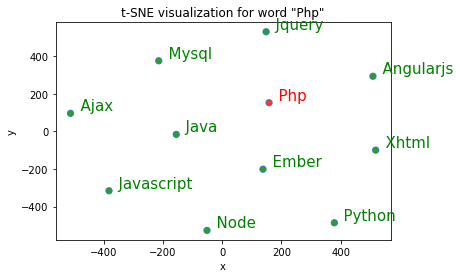

In [36]:
# tsne plot for top 10 similar word to 'chicken'
tsne_plot(for_word='php', w2v_model=fast_Text_model)

## Modelisation

In [53]:
import numpy as np

In [61]:
mean_description = []
for clean_val in word_tokens:
    mean_descrip = np.mean([fast_Text_model.wv[x] for x in clean_val], axis=0)
    mean_description.append(mean_descrip)

In [62]:
len(mean_description)

6673

In [64]:
model_df = pd.DataFrame(mean_description)

In [67]:
model_df['target'] = df['category']

In [68]:
model_df.head()

,0,1,2,3,4,5,6,7,8,9,...,291,292,293,294,295,296,297,298,299,target
0,0.000537,0.061436,-0.177338,0.093104,-0.033738,0.091043,0.154721,-0.042880,-0.023236,-0.133889,...,0.077545,-0.173614,0.159851,0.111940,0.032545,-0.142774,-0.207894,-0.121579,-0.229990,it
1,0.074989,0.003745,-0.214197,0.132305,-0.065197,0.095900,0.277600,-0.074231,-0.143516,-0.018421,...,0.145595,-0.243770,0.117161,0.146426,0.115786,-0.105279,-0.104396,-0.051458,-0.204164,experienced
2,0.008570,0.025629,-0.108684,0.131971,-0.002385,0.006054,0.221696,0.092372,0.001577,-0.082162,...,0.091170,-0.143457,0.129136,0.085668,0.101278,-0.118130,-0.113353,0.011193,-0.124432,customer support
3,0.028448,0.124344,-0.096533,0.143635,-0.073637,0.075153,0.100439,-0.005960,-0.068829,-0.080395,...,0.102881,-0.202315,0.163710,-0.004122,0.009899,-0.079401,-0.272837,-0.035393,-0.109633,customer support
4,0.113256,-0.061997,-0.132299,0.129360,0.022835,0.066457,0.228832,0.024359,-0.051603,-0.098156,...,0.067217,-0.152840,0.181807,0.061525,0.051725,-0.089332,-0.194775,0.004176,-0.139168,customer support


In [338]:
filter_df = model_df[model_df["target"]=="it"][:100].copy()

In [339]:
ct = list(model_df['target'].unique())
for c in ct:
    if c != "it":
        filter_df = pd.concat([filter_df,model_df[model_df["target"]==c][:100]])

In [340]:
#filter_df.target.unique()

In [341]:
#filter_df.groupby('target')['target'].count().sort_values().index

In [342]:
filter_df = filter_df[filter_df['target'].isin(['administrative', 'building construction', 'student', 'security',
       'education', 'business', 'biotech', 'engineering', 'human', 'general',
       'customer support', 'sales', 'entry', 'quality assurance',
       'experienced', 'food services', 'medical', 'marketing',
       'manufacturing', 'logistics', 'legal', 'installation','it'])]

<AxesSubplot:ylabel='target'>

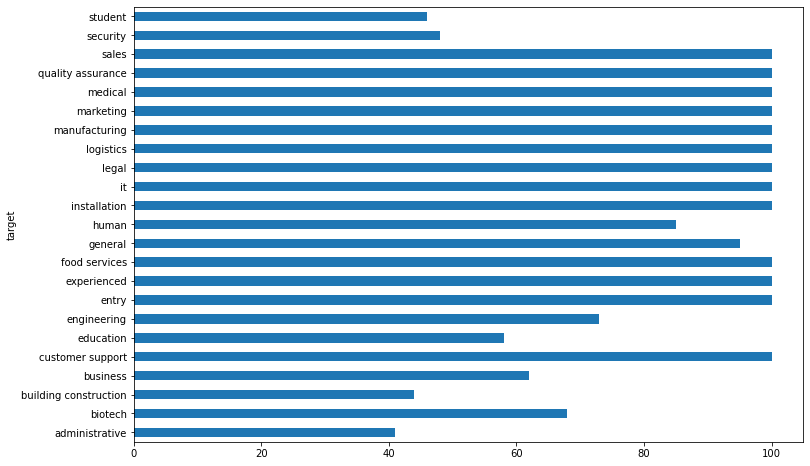

In [343]:
filter_df.groupby('target')['target'].count().plot(kind='barh', figsize=(12,8))

In [344]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import time, math
from sklearn.metrics import accuracy_score

In [345]:
X = filter_df.drop(columns=['target'])

le = preprocessing.LabelEncoder()
y = le.fit_transform(list(filter_df.target))

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.33, random_state=1)

In [346]:
from sklearn.ensemble import RandomForestClassifier

cols_results=['family','model','classification_rate','runtime']
results = pd.DataFrame(columns=cols_results)
rVals = range(1,4)
rf_names = ['RF-'+str(int(math.pow(10,r))) for r in rVals]
for r in rVals:
    clf = RandomForestClassifier(n_estimators=int(math.pow(10,r)),random_state=0)
    time_start = time.time()
    clf.fit(X_train,y_train)
    time_run = time.time()-time_start
    y_pred=clf.predict(X_test)
    
    results = results.append(pd.DataFrame([['RF',rf_names[r-1],accuracy_score(y_test,y_pred),time_run]],columns=cols_results),ignore_index=True)
    
results[results.family=='RF']

,family,model,classification_rate,runtime
0,RF,RF-10,0.485804,0.221094
1,RF,RF-100,0.591483,2.084646
2,RF,RF-1000,0.619874,21.063822


## Use the model

In [412]:
description = """IT ASSOCIATE, Abdul Latif Jameel Poverty Action Lab (J-PAL), to assist with day-to-day end-user support, including creating system images, setting up new machines for staff, provisioning accounts, troubleshooting user issues, data import and cleaning activities, assisting with reporting, 
creating user documentation, and working with senior staff to improve overall technology deployment. 
Specific responsibilities may include responding to support tickets for user support and researching problems 
prior to escalation, assisting staff with troubleshooting hardware issues and escalating when necessary, 
creating new accounts, shutting down old accounts and resetting passwords, work with the IT team to import data, 
identify and merge duplicates and clean data using defined processes, monitor spam and alert the IT team to any 
suspicious activity, and assist staff with creating reports and dashboards on Salesforce."""

In [393]:
description = """The Vertex Summer Co-op Program offers students the opportunity to learn about the pharmaceutical industry from a hands-on perspective. 
You will be working closely with and learning from some of the brightest people in the industry."""

In [398]:
description = """In the clinical area the practice assistant, under the direction and supervision of a licensed Nurse or Provider, and in accordance with 
hospital policies, procedures, protocols, and standards of practice participates in the delivery of patient care."""

In [413]:
clean_desc = process_text(description)
mean_desc = np.mean([fast_Text_model.wv[x] for x in clean_desc], axis=0)

In [414]:
predict_label = clf.predict(np.array(mean_desc).reshape(1, -1))[0]

In [415]:
le.classes_[predict_label]

'business'

In [416]:
clf.predict_proba(np.array(mean_desc).reshape(1, -1))[0][predict_label]

0.072

In [417]:
clf.predict_proba(np.array(mean_desc).reshape(1, -1))[0]

array([0.016 , 0.054 , 0.044 , 0.072 , 0.051 , 0.023 , 0.056 , 0.059 ,
       0.052 , 0.021 , 0.042 , 0.062 , 0.021 , 0.064 , 0.036 , 0.0166,
       0.0594, 0.063 , 0.037 , 0.063 , 0.056 , 0.01  , 0.022 ])